In [32]:
import sys
sys.path.append('/Users/jamieoswald/anaconda3/lib/python3.6/site-packages/sympy')
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [33]:
def get_stock_data(stock_name, isTraining, normalized=0):
    url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name
    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    #if not isTraining:
       # df1 = pd.DataFrame({'Date': ["2017-04-26"],
                   #       'Open': [312.37],
                         # 'High': [314.50],
                        #  'Low': [310.25],
                        #  'Close': [0],
                        #  'Volume': [0],
                        #  'Adj Close': [0]},
                        #  index= [0])
        #frames = [df1, df]
        #df = pd.concat(frames)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    date_store = df
    #df.drop(df.columns[[0,2,4,6, 7,8,9]], axis=1, inplace=True) 
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True)
    return df, date_store

In [31]:
stock_name = 'TSLA'
df, date_store = get_stock_data(stock_name,0, True)
df.head(23)

,Open,High,Close
0,325.480011,327.000000,324.809998
1,323.399994,326.000000,323.100006
2,321.559998,325.500000,325.220001
3,309.380005,321.989990,321.260010
4,310.899994,313.790009,307.190002
5,298.000000,308.549988,308.350006
6,307.440002,307.769989,295.459991
7,317.670013,321.529999,311.019989
8,324.000000,327.660004,318.890015
9,314.880005,327.250000,322.829987


In [19]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [20]:
df['High'] = df['High'] / 100
df['Open'] = df['Open'] / 100
df['Close'] = df['Close'] / 100
df.head(5)

,Open,High,Close
0,3.2548,3.2700,3.2481
1,3.2340,3.2600,3.2310
2,3.2156,3.2550,3.2522
3,3.0938,3.2199,3.2126
4,3.1090,3.1379,3.0719


In [21]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [22]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
        return model

In [23]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

print(X_train)

X_train (1203, 22, 3)
y_train (1203,)
X_test (134, 22, 3)
y_test (134,)
[[[ 0.2867      0.2917      0.28620001]
  [ 0.28790001  0.2893      0.28      ]
  [ 0.2809      0.285       0.2775    ]
  ..., 
  [ 0.284       0.285       0.22790001]
  [ 0.26620001  0.2734      0.266     ]
  [ 0.26690001  0.26879999  0.26809999]]

 [[ 0.28790001  0.2893      0.28      ]
  [ 0.2809      0.285       0.2775    ]
  [ 0.28049999  0.28450001  0.279     ]
  ..., 
  [ 0.26620001  0.2734      0.266     ]
  [ 0.26690001  0.26879999  0.26809999]
  [ 0.27190001  0.2774      0.2676    ]]

 [[ 0.2809      0.285       0.2775    ]
  [ 0.28049999  0.28450001  0.279     ]
  [ 0.2791      0.2807      0.2757    ]
  ..., 
  [ 0.26690001  0.26879999  0.26809999]
  [ 0.27190001  0.2774      0.2676    ]
  [ 0.269       0.27        0.266     ]]

 ..., 
 [[ 2.05990005  2.10179993  2.07449997]
  [ 2.065       2.11        2.08990005]
  [ 2.09649994  2.09979996  2.05809998]
  ..., 
  [ 2.02119995  2.03        1.99100006]
  [

In [24]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

In [25]:
model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=500,
    validation_split=0.1,
    verbose=1)

Train on 1082 samples, validate on 121 samples
Epoch 1/500
1082/1082 [==============================] - 2s - loss: 2.9529 - acc: 0.0000e+00 - val_loss: 3.4318 - val_acc: 0.0000e+00
Epoch 2/500
1082/1082 [==============================] - 1s - loss: 1.9980 - acc: 0.0000e+00 - val_loss: 2.0345 - val_acc: 0.0000e+00
Epoch 3/500
1082/1082 [==============================] - 1s - loss: 1.2029 - 

In [26]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.02 MSE (0.15 RMSE)


In [27]:
get_stock_data(stock_name, 0 , False)
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1203, 22, 3)
y_train (1203,)
X_test (134, 22, 3)
y_test (134,)


In [28]:
print(X_test)
print(y_test)
#getPredictionData('TSLA',0)
window = 22
diff=[]
ratio=[]
p = model.predict(X_test)

for u in range(0, len(X_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    

print(p)

[[[ 2.07509995  2.0825      2.06270004]
  [ 2.05600006  2.07330002  2.00699997]
  [ 2.02210007  2.04979996  2.04029999]
  ..., 
  [ 2.02899994  2.04690002  2.02339996]
  [ 2.01        2.03190002  2.02240005]
  [ 2.11339996  2.13699997  2.04009995]]

 [[ 2.05600006  2.07330002  2.00699997]
  [ 2.02210007  2.04979996  2.04029999]
  [ 2.12300003  2.15669998  2.13699997]
  ..., 
  [ 2.01        2.03190002  2.02240005]
  [ 2.11339996  2.13699997  2.04009995]
  [ 2.04        2.05320007  1.99970001]]

 [[ 2.02210007  2.04979996  2.04029999]
  [ 2.12300003  2.15669998  2.13699997]
  [ 2.13100006  2.13320007  2.11410004]
  ..., 
  [ 2.11339996  2.13699997  2.04009995]
  [ 2.04        2.05320007  1.99970001]
  [ 2.02490005  2.02490005  1.97729996]]

 ..., 
 [[ 2.96880005  3.01940002  2.98700012]
  [ 2.975       3.02690002  3.02540009]
  [ 3.09149994  3.13730011  3.12390015]
  ..., 
  [ 3.07440002  3.07769989  2.95459991]
  [ 2.98        3.08549988  3.08350006]
  [ 3.10899994  3.13790009  3.07190

Expected value:  323.100006
Last Input:  [[ 309.149994  313.730011  312.390015]
 [ 313.380005  313.470001  308.709991]
 [ 306.339996  308.450012  296.839996]
 [ 296.700012  307.390015  304.      ]
 [ 302.700012  304.        301.440002]
 [ 299.700012  300.839996  300.25    ]
 [ 302.459991  306.619995  305.519989]
 [ 306.51001   309.149994  302.51001 ]
 [ 302.        306.399994  305.600006]
 [ 309.220001  310.549988  308.029999]
 [ 308.        313.980011  313.790009]
 [ 312.369995  314.5       310.170013]
 [ 311.690002  313.089996  308.630005]
 [ 309.829987  314.799988  314.070007]
 [ 314.880005  327.25      322.829987]
 [ 324.        327.660004  318.890015]
 [ 317.670013  321.529999  311.019989]
 [ 307.440002  307.769989  295.459991]
 [ 298.        308.549988  308.350006]
 [ 310.899994  313.790009  307.190002]
 [ 309.380005  321.98999   321.26001 ]
 [ 321.559998  325.5       325.220001]]
Last Prediction:  [ 284.08209229]


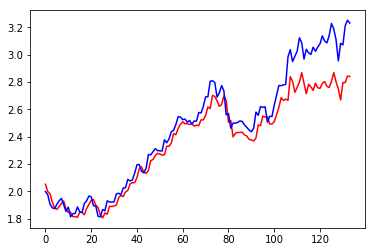

In [29]:
import matplotlib.pyplot as plt2
print("Expected value: ",(y_test[-1] * 100))
print("Last Input: ",(X_test[-1] * 100))
print("Last Prediction: ",(p[-1] * 100))
plt2.plot(p ,color='red', label='prediction')
plt2.plot(y_test ,color='blue', label='y_test')
#plt2.legend(loc='upper left')
plt2.show()